## Implementing the GBDT with XG-BOOST technique

In [2]:
#IMPORTING ALL THE RELEVANT LIBRARIES
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import datetime as dt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings(action='ignore')

from prettytable import PrettyTable


### Connecting to the pre-processed SQL-ITE Database

In [3]:
#Connecting to the SQL table
con = sqlite3.connect('final.sqlite')

#Reading data from the database

Data = pd.read_sql_query("""
SELECT *
FROM Reviews """,con)
Data.shape

# Drop index column
Data.drop(columns=['index'],inplace=True)


### Setting the dataframe in proper format for further use

In [4]:
# Convert timestamp to datetime.

Data['Time'] = Data[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

#Setting Time column as index of the dataframe 
Data.set_index("Time",inplace=True)

#Sampling the above data

Sampled_data=Data.sample(n=100000,replace='False')
Sorted=Sampled_data.sort_index()

Sorted.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,CleanedText
Time,,,,,,,,,,
1999-10-25 05:30:00,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
1999-12-02 05:30:00,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
2000-01-09 05:30:00,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
2000-08-15 05:30:00,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,positive,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",great film dont even know sum first complet or...
2001-09-24 05:30:00,374449,B00004CI84,A3K3YJWV0N54ZO,Joey,2,3,positive,"Beetlejuice is a greatmovie, but they cheated ...",Just to warn you. when in trying to trick you ...,warn tri trick widescreen format compani made ...


### Plotting the frequency distribution of the class label

In [5]:
Sorted["Score"].value_counts()

positive    84348
negative    15652
Name: Score, dtype: int64

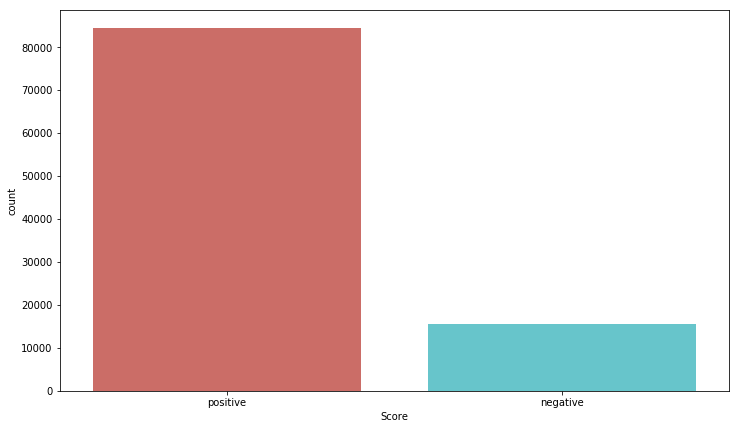

<Figure size 864x504 with 0 Axes>

In [6]:
polarity=Sorted["Score"]
sns.countplot(x="Score",data=Sorted,palette="hls")
plt.show()
plt.savefig("count_plot")


<h2>Observations</h2>
<ul>
    <li>Here after all the text-preprocesing and the data-cleaning only 364k datapoints remained.</li>
    <li>I have taken a sample size of 100k and also the whole data out of the total population for the purpose of analyzing and studying the behaviour of the data by applying the Gradient-boosting decision trees algorithm over it.</li>
    <li>First I took the "TIME" column and set as the index of the new sampled dataframe and then sorted accordingly in ascending order since the data has a temporal nature.</li>
    <li>By setting the "SCORE" column as a class label for classifying the reviews as a positive and negative.</li>
    <li>By observing the above bar plot it is clear that the above dataset is highly imbalanced and this may cause problems in the future analysis.</li>
</ul>
    
    

### Splitting the datapoints into 70:30 split 

In [7]:
def data_split(x,y):
    #Splitting the model into 70:30 split of Training and Cross_validate split
    X_tr, X_test, y_tr, y_test = train_test_split(x, y, test_size=0.3,shuffle=False,random_state=None)


    return X_tr,y_tr,X_test,y_test

### Preparing the data-points for further use 

In [8]:
X=Sorted
Y=polarity

X_tr,y_tr,X_test,y_test=data_split(X,Y)

print("The shape of x_train is:",X_tr.shape)
print("the shape of y_train is:",y_tr.shape)
print("the shape of x_test is:",X_test.shape)
print("the shape of y_test is:",y_test.shape)


# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_tr)
test_y = encoder.fit_transform(y_test)

The shape of x_train is: (70000, 10)
the shape of y_train is: (70000,)
the shape of x_test is: (30000, 10)
the shape of y_test is: (30000,)


###  Utitlity function for training and cross-validation of the data

In [9]:

def modelfit(alg,x_tr,y_tr,x_test,y_test):
    
    #Fit the algorithm on the data
    alg.fit(x_tr, y_tr,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_test)
    dtrain_predprob = alg.predict_proba(x_test)[:,1]
     
    accuracy= metrics.accuracy_score(y_test, dtrain_predictions)
    
    Auc_score= metrics.roc_auc_score(y_test, dtrain_predprob)
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy)
    print ("AUC Score (Train): %f" % Auc_score)
    
     # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test,dtrain_predprob)
    #TITLE OF THE PLOT
    plt.title('Receiver Operating Characteristic of Test set')
    #LABEL OF THE PLOT
    label=('AUC = %0.2f'%  Auc_score)
    
    #plt.legend(loc='lower right')
     
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
# show the plot
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
                  
    #feature importance of the above model
    feat_imp=xgb.plot_importance(alg,max_num_features=25)
    #feat_imp.plt(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return dtrain_predictions ,dtrain_predprob, accuracy, Auc_score

def Gridsearch_tuning(param,x_tr,y_tr,predictor=None,pred_name=None):
    
    model = XGBClassifier()
   
    param_grid=param
   
    kfold = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(x_tr, train_y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

def Prec_rec_curve(testy, probs,yhat):
# calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(testy, probs)
# calculate F1 score
    f1 = f1_score(testy, yhat)
# calculate precision-recall AUC
    Auc = auc(recall, precision)
# calculate average precision score
    ap = average_precision_score(testy, probs)
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, Auc, ap))
    
    plt.title('Precision recall curve of Test set')
# plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
    plt.plot(recall, precision, marker='.')
    
    plt.ylabel('Precision')
    plt.xlabel('Recall')
# show the plot
    plt.show()


### Function for Vectorizing the data (BOW & TF-IDF)

In [10]:

#Function for vectorizing the train data

from sklearn.feature_extraction.text import TfidfVectorizer

def vec_train(vect,X_tr):
    import warnings
    warnings.filterwarnings("ignore")

    count_vect = vect #in scikit-learn
    BOW = count_vect.fit_transform(X_tr.values)
    return count_vect,BOW


#Function for vectorizing the CV data

def vec_cv(count,X_cv):
    cv=count.transform(X_cv.values)
    cv.get_shape()
    
    return cv


#Function for vectorizing the test data
def vec_test(count,X_test):
    test=count.transform(X_test.values)
    test.get_shape()
    
    return test

#Funtion for printing the total number of top features
def top_tfidf_feats(name,row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', name]
    return df



### Utility function for plotting the confusion matrix 

In [11]:

from sklearn.metrics import confusion_matrix
def Confusion_metric(y_test,y_pred):
    print(metrics.confusion_matrix(y_test,y_pred))
    confusion=metrics.confusion_matrix(y_test,y_pred)

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Predicted label');
    plt.xlabel('Actual label');
    
    plt.show()

#Storing the values of the confusion matrix
    TN=confusion[0,0]
    FP=confusion[0,1]
    FN=confusion[1,0]
    TP=confusion[1,1]

# use float to perform true division, not integer division
    Class_acc=((TP + TN) / float(TP + TN + FP + FN))*100

#Code for classification error

    classification_error = ((FP + FN) / float(TP + TN + FP + FN))*100
    

#Code for finding the TPR,FPR,TNR,FNR

    TPR = (TP / float(FN + TP))*100

    FNR = (FN / float(FN + TP))*100

    TNR=(TN / float(TN + FP))*100

    FPR=(FP / float(TN + FP))*100
    
#Code for finding the Precision,Recall & F1_score    
   
    precision = (TP/float(TP+FP))*100
    
    recall= (TP / float(FN + TP))*100
    
    F1_s= ((float(precision*recall)/float(precision+recall))*2)
    
    print()
    
    ptable=PrettyTable()
    ptable.title="The performance metrics of the above model are as follows: "
    ptable.field_names=["Metrics","Scores"]
    ptable.add_row(["Classification accuracy",Class_acc])
    ptable.add_row(["Classification_error",classification_error])
    ptable.add_row(["True positive",TP])
    ptable.add_row(["False positive",FP])
    ptable.add_row(["True negative",TN])
    ptable.add_row(["False negative",FN])
    ptable.add_row(["True positive rate",TPR])
    ptable.add_row(["False negative rate",FNR])
    ptable.add_row(["True negative rate",TNR])
    ptable.add_row(["False positive rate",FPR])
    ptable.add_row(["Precision value",precision])
    ptable.add_row(["Recall value",recall])
    ptable.add_row(["f1_score value",F1_s])
    
    print(ptable)
    

In [48]:
def conclusion_table():
    print()
    ptable=PrettyTable()
    ptable.title="The comparisons of all the vectorizers and scorings are as follows: "
    ptable.field_names=["Vectorizer","Algorithm","ROC_AUC score","Precision-recall curve score"]
    ptable.add_row(["Bag-Of-Words","XG-BOOST",Auc_Score,"0.971"])
    ptable.add_row(["Tf-IDF","XG-BOOST",TfAuc_score ,"0.974"])
    ptable.add_row(["Average-word2vec","XG-BOOST",avg_Auc_Score ,"0.976"])
    ptable.add_row(["TF-IDF-Weighted-word2vec","XG-BOOST",Tf_Auc_Scor,"0.987"])
      
    print(ptable)
    
    

### Implementing the Bag-of words vectorizer

In [12]:

#Initializing the count vectorizer 
Count_vect=CountVectorizer()

#vectorizing the X_train set
count,x_tr=vec_train(Count_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",x_tr.shape)

#Vectorizing the X_test set
x_test=vec_test(count,X_test["CleanedText"])
print("The shape of the X_test is: ",x_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the Bow score are as follows")
features = Count_vect.get_feature_names()
len(features)


top_Bow = top_tfidf_feats("bow",x_tr[1,:].toarray()[0],features,25)
top_Bow




The shape of the X_train is:  (70000, 29975)
The shape of the X_test is:  (30000, 29975)

Top 25 feaures acording to the Bow score are as follows


,feature,bow
0,movi,2
1,delight,1
2,written,1
3,view,1
4,effect,1
5,well,1
6,excel,1
7,everyth,1
8,special,1
9,act,1


### Training the model over the test set with default parameters 


Model Report
Accuracy : 0.8579
AUC Score (Train): 0.879699


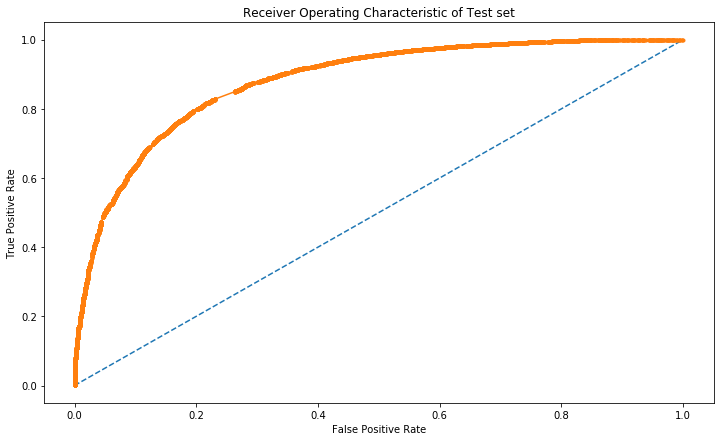

--- 3.7512474060058594 seconds ---


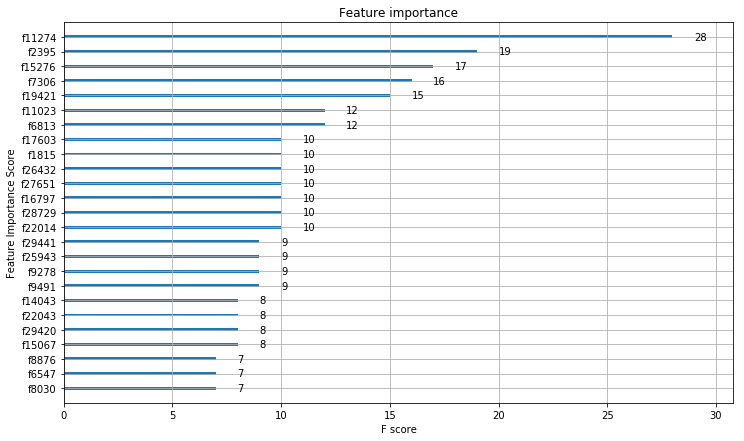

In [13]:
# Trainig the model on default parameters

import time
start_time = time.time()

xgb1= XGBClassifier(objective= 'binary:logistic',nthread=4,n_jobs =-1)

y_pred,y_predprob,accuracy,Auc_score=modelfit(xgb1,x_tr,train_y,x_test,test_y)

print("--- %s seconds ---" % (time.time() - start_time))


f1=0.920 auc=0.968 ap=0.968


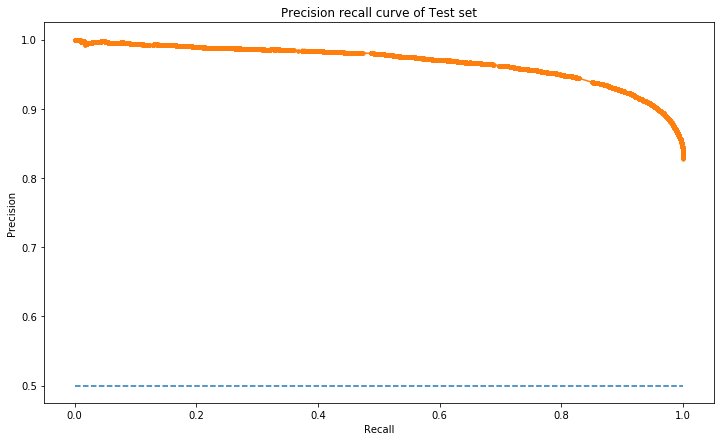

In [14]:
Prec_rec_curve(test_y,y_predprob,y_pred)

<ul><h3><center> AUC-ROC CURVE</center></h3>
    <li>The above XG-Boost model is trained with default parameters by keeping "AUC" as evaluation metric but after training the model the AUC score is descent(0.8601) so the model is a good one instead of high accuracy,Since the confusion matrix is not sensible and the data is highly imbalanced.
    <li>ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.</li>
    <li>So I plotted the ROC curve in which the blue dotted line is the "No-skill line" means the model which Lie over it is a random-model which does not classiffy at all.The Auc scores ranges from (0 to 1) and for the random model = 0.5.</li>
    <li>If a model lies above 0.5 then it is a sensible model and if a model lies below of it than it is worst model.</li>
    <li>So our xg-boost model is a bad model as it lies below the random one and does a bad job of classification of reviews.</li>
    <h3><center> PRECSION-RECALL CURVE</center></h3>
    <li>In the second plot I plotted the Precision-recall curve which is a trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.</li>
    <li>The no-skill line is defined by the total number of positive cases divide by the total number of positive and negative cases. For a dataset with an equal number of positive and negative cases, this is a straight line at 0.5. Points above this line show skill.</li>
    <li>A model with perfect skill is depicted as a point at [1.0,1.0]. A skilful model is represented by a curve that bows towards [1.0,1.0] above the flat line of no skill.</li>
    <li>There are also composite scores that attempt to summarize the precision and recall; three examples include:</li>
        <ol>
            <li>F score or F1 score: that calculates the harmonic mean of the precision and recall (harmonic mean because the        precision and recall are ratios).</li>
            <li>Average precision: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.</li>
            <li>Area Under Curve: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.</li>
    </ol>
    <li> In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.</li>
    <li>This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class so hence the model's AUC inreased from 0.49 to 0.820 with a good precision and recall scores.</li>


###  Confusion matrix of the above model

[[ 1084  4147]
 [  115 24654]]


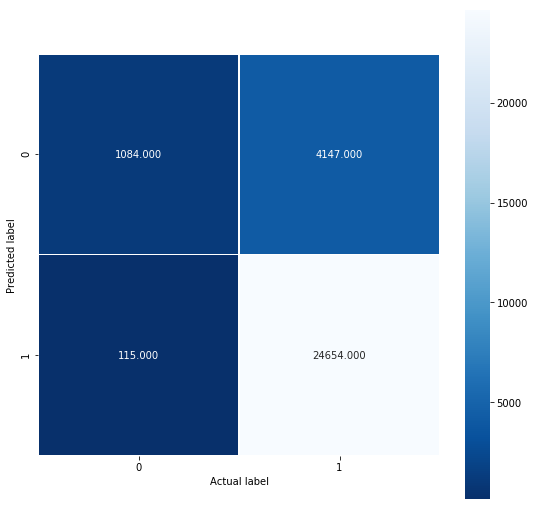


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |     85.79333333333334     |
|       Classification_error      |     14.206666666666667    |
|          True positive          |           24654           |
|          False positive         |            4147           |
|          True negative          |            1084           |
|          False negative         |            115            |
|        True positive rate       |     99.53570996003069     |
|       False negative rate       |     0.4642900399693165    |
|        True negative rate       |     20.722615178742114    |
|       False positive rate       |      79.2773848212579     |
|         Precision value         |    

In [15]:
Confusion_metric(test_y,y_pred)

### Tuning the Hyperparameter with Gridsearch technique

In [38]:
import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,300,500,700,900,1100,1300] # Total number of base learners
learning_rate = [0.0001, 0.001, 0.01, 0.1] #Total gamma values
Max_depth=[1,2,3] #Depth of the trees

#Creating dictionary of parameters to be considered
param= dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=Max_depth)

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(param,x_tr,train_y,n_estimators,"n_estimators")


print("--- %s seconds ---" % (time.time() - start_time))


Best: 0.923472 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1300}
0.547516 (0.010653) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 100}
0.547516 (0.010653) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 300}
0.547516 (0.010653) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 500}
0.559535 (0.016532) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 700}
0.559535 (0.016532) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 900}
0.573096 (0.042909) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1100}
0.573091 (0.042899) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1300}
0.592113 (0.046590) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100}
0.615170 (0.032233) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 300}
0.634610 (0.046484) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 500}
0.647340 (0.041133) with: 

____Testing the above model with optimal hyperparameter values____ 


Model Report
Accuracy : 0.8624
AUC Score (Train): 0.890453


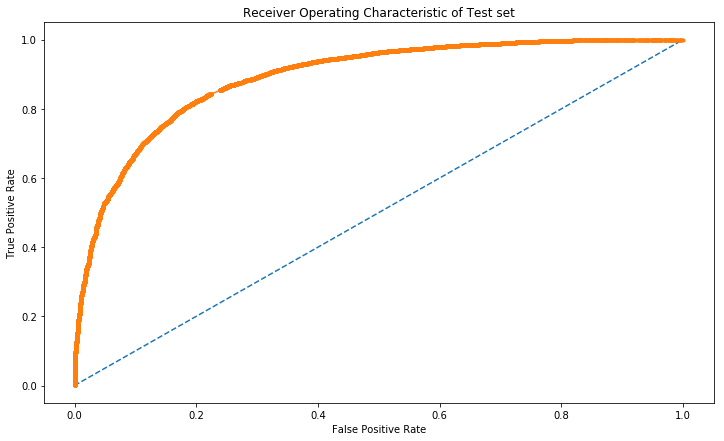

--- 38.05816578865051 seconds ---


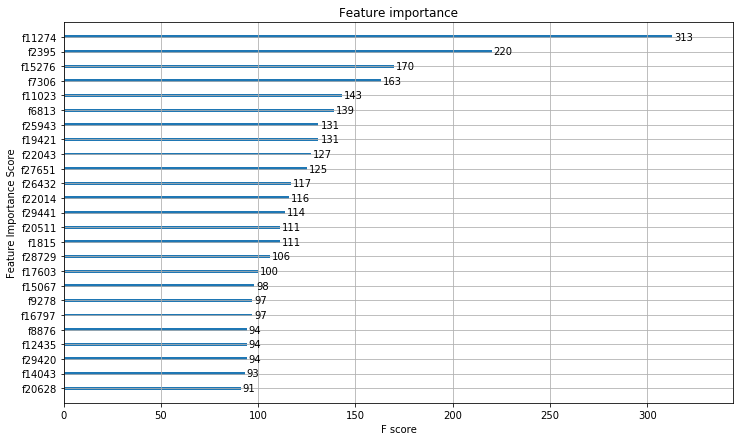

In [16]:
# Trainig the model on default parameters

import time
start_time = time.time()

xgb2= XGBClassifier(
 learning_rate =0.01,
 n_estimators=1300,
 max_depth=3,
 objective= 'binary:logistic',
 nthread=4,
 n_jobs =-1)

Y_pred,Y_predprob,Accuracy,Auc_Score=modelfit(xgb2,x_tr,train_y,x_test,test_y)

print("--- %s seconds ---" % (time.time() - start_time))


f1=0.923 auc=0.971 ap=0.971


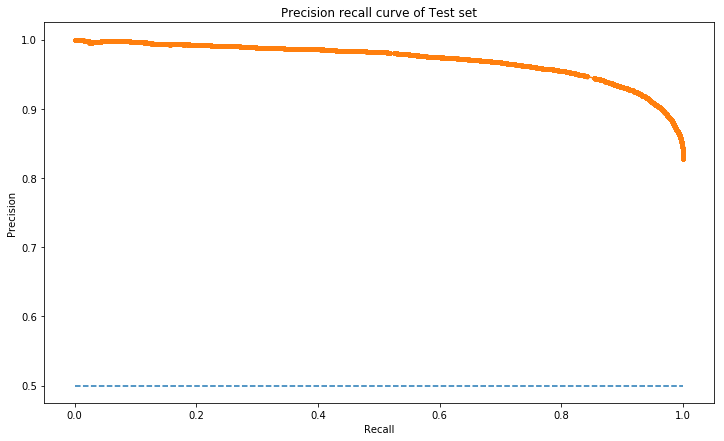

In [17]:
Prec_rec_curve(test_y,Y_predprob,Y_pred)

[[ 1240  3991]
 [  136 24633]]


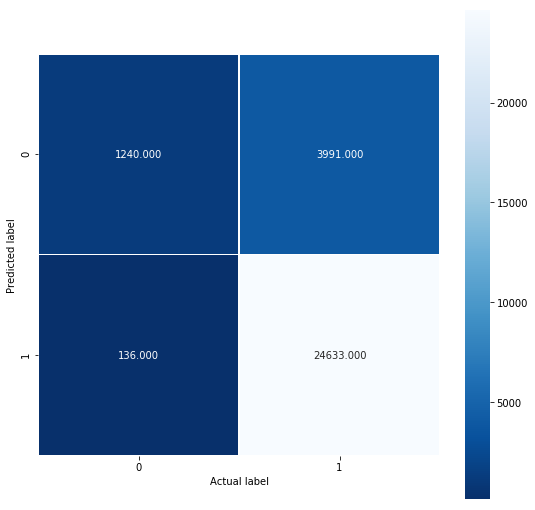


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |     86.24333333333334     |
|       Classification_error      |     13.756666666666668    |
|          True positive          |           24633           |
|          False positive         |            3991           |
|          True negative          |            1240           |
|          False negative         |            136            |
|        True positive rate       |      99.4509265614276     |
|       False negative rate       |     0.5490734385724091    |
|        True negative rate       |     23.70483655132862     |
|       False positive rate       |     76.29516344867137     |
|         Precision value         |    

In [18]:
Confusion_metric(test_y,Y_pred)

### Observations
<ul>
    <li>After tuning the hyperparameters the model's AUC score increased by 0.1% this improvement is still significant for our  model.</li>
    <li>The model is not sensible as the confudion matrix of the model does not make any sense.</li>
    <li>So when AUC is taken as a metric for the model has failed to classify the positive and negative reviews properly on Bag-of-word vectorized technique.</li>
    <li>In the Precison recall curve there is a significant improvement in the model as the F1-score is used as a prime metric and this method is much robust to class imbalance because f1-score is a harmonic mean and treats both the precision and recall equally.</li>
<li>So clearly accuracy and AUC-ROC as a metric fails in this vectorization technique.</li>

## Implementing  Tf-IDF Vectorization technique 

In [19]:
#Initializing the count vectorizer 
TFIDF_vect=TfidfVectorizer(ngram_range=(1,2),min_df=5)

#vectorizing the X_train set
TF,tfx_tr=vec_train(TFIDF_vect,X_tr["CleanedText"])

print("The shape of the X_train is: ",tfx_tr.shape)

#Vectorizing the X_test set
tfx_test=vec_test(TF,X_test["CleanedText"])
print("The shape of the X_test is: ",tfx_test.shape)


#Printing the total length of the features
print("\nTop 25 feaures acording to the TF-IDF score are as follows")
TF_features = TFIDF_vect.get_feature_names()
len(TF_features)


top_TFIDF = top_tfidf_feats("TFIDF",tfx_tr[1,:].toarray()[0],TF_features,25)
top_TFIDF



The shape of the X_train is:  (70000, 96805)
The shape of the X_test is:  (30000, 96805)

Top 25 feaures acording to the TF-IDF score are as follows


,feature,TFIDF
0,movi,0.536460
1,beetlejuic,0.380496
2,view,0.314732
3,written,0.297139
4,act,0.284197
5,chose,0.278081
6,delight,0.220474
7,effect,0.216246
8,special,0.209587
9,everyth,0.195233


### Training the model over the Test-set with default parameters 


Model Report
Accuracy : 0.8593
AUC Score (Train): 0.886385


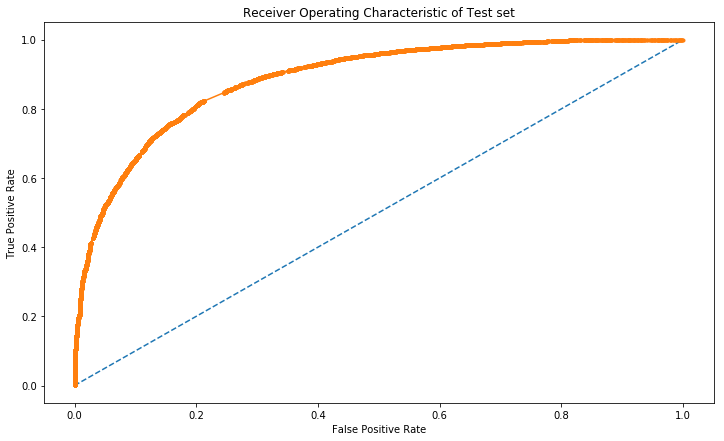

--- 11.350945711135864 seconds ---


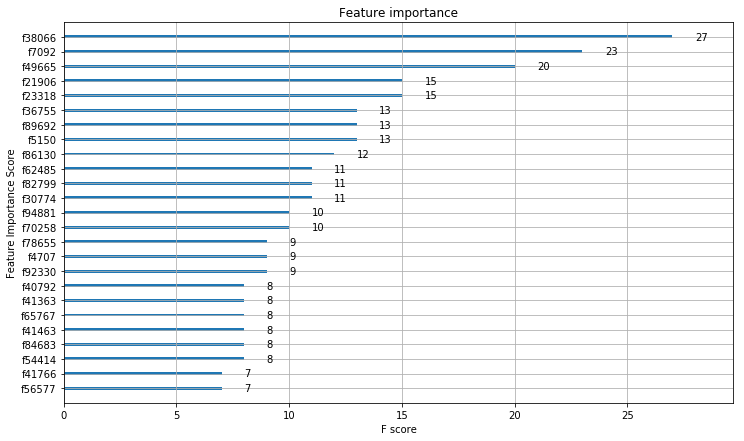

In [20]:
# Trainig the model on default parameters

import time
start_time = time.time()

xgb3= XGBClassifier(objective= 'binary:logistic',nthread=4,scale_pos_weight=1,n_jobs =-1)

tfy_pred,tfy_predprob,tfaccuracy,tfAuc_score=modelfit(xgb3,tfx_tr,train_y,tfx_test,test_y)

print("--- %s seconds ---" % (time.time() - start_time))


f1=0.921 auc=0.970 ap=0.970


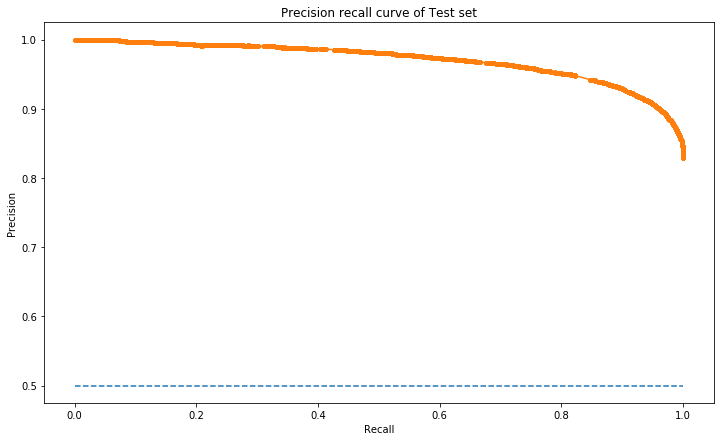

In [21]:
Prec_rec_curve(test_y,tfy_predprob,tfy_pred)

[[ 1128  4103]
 [  117 24652]]


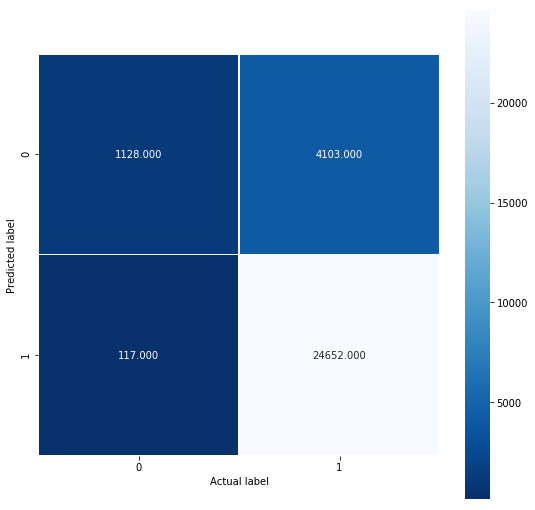


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |     85.93333333333332     |
|       Classification_error      |     14.066666666666666    |
|          True positive          |           24652           |
|          False positive         |            4103           |
|          True negative          |            1128           |
|          False negative         |            117            |
|        True positive rate       |     99.52763535063991     |
|       False negative rate       |    0.47236464936008715    |
|        True negative rate       |     21.563754540240872    |
|       False positive rate       |     78.43624545975912     |
|         Precision value         |    

In [23]:
Confusion_metric(test_y,tfy_pred)

## Tuning the Hyperparameter with Gridsearch technique

In [45]:
import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,400,500,1000,1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
Max_depth=[1,2,3,4,5]

#Creating dictionary of parameters to be considered
tfparam= dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=Max_depth)

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(tfparam,tfx_tr,train_y,n_estimators,"n_estimators")


print("--- %s seconds ---" % (time.time() - start_time))


Best: 0.929219 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1500}
0.544003 (0.015304) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 100}
0.544003 (0.015304) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 400}
0.544003 (0.015304) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 500}
0.547175 (0.011271) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1000}
0.552500 (0.006648) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1500}
0.581204 (0.036721) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100}
0.607054 (0.046643) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 400}
0.620029 (0.055597) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 500}
0.631339 (0.057705) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 1000}
0.656672 (0.039592) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 1500}
0.589821 (0.031829) with

____Testing the above model with optimal hyperparameter values____ 


Model Report
Accuracy : 0.868
AUC Score (Train): 0.900496


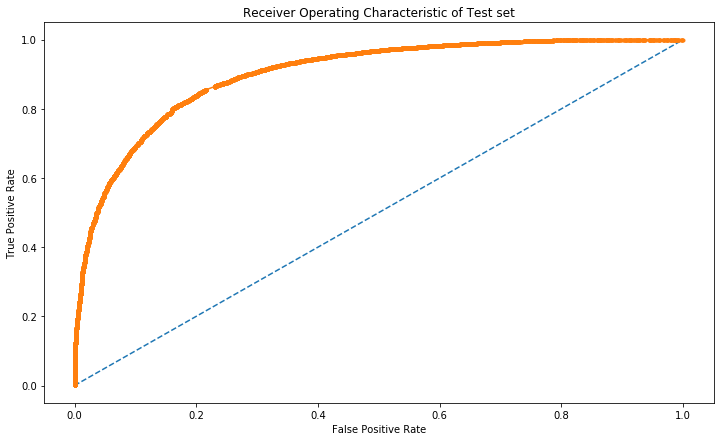

--- 148.9593517780304 seconds ---


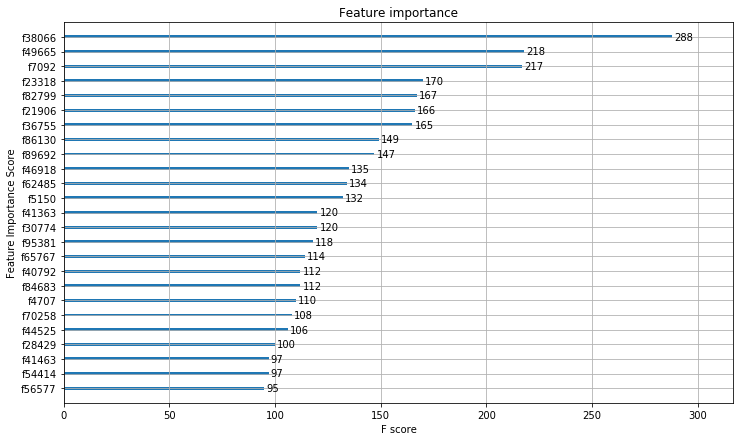

In [24]:
# Trainig the model on default parameters

import time
start_time = time.time()

xgb4= XGBClassifier(
 learning_rate =0.01,
 n_estimators=1500,
 max_depth=3,
 objective= 'binary:logistic',
 nthread=4,
  n_jobs =-1)

Tfy_pred,Tfy_predprob,Tfaccuracy,TfAuc_score=modelfit(xgb4,tfx_tr,train_y,tfx_test,test_y)

print("--- %s seconds ---" % (time.time() - start_time))


f1=0.926 auc=0.974 ap=0.974


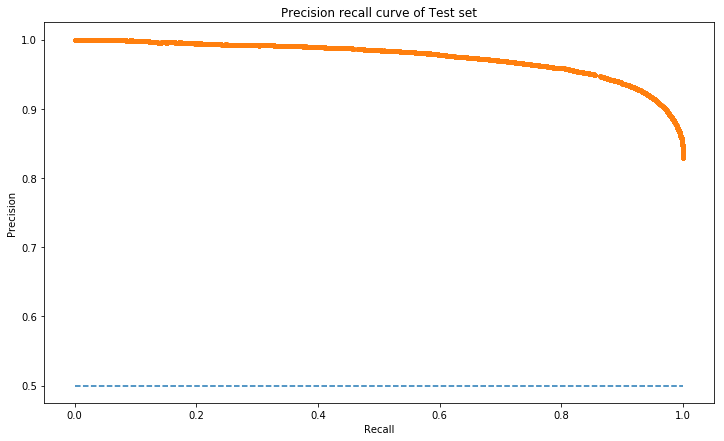

In [25]:
Prec_rec_curve(test_y,Tfy_predprob,Tfy_pred)

[[ 1415  3816]
 [  145 24624]]


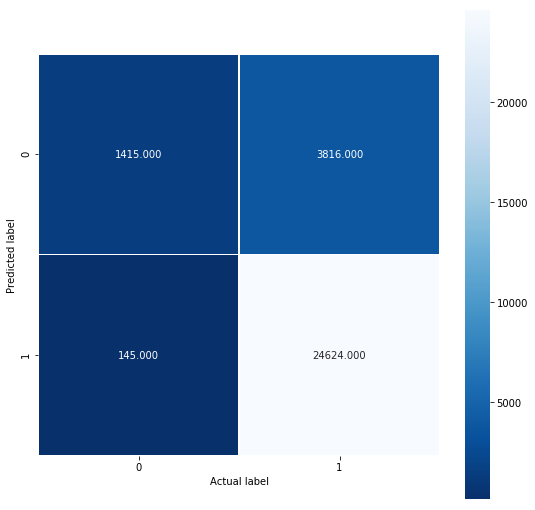


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |     86.79666666666667     |
|       Classification_error      |     13.203333333333333    |
|          True positive          |           24624           |
|          False positive         |            3816           |
|          True negative          |            1415           |
|          False negative         |            145            |
|        True positive rate       |     99.41459081916912     |
|       False negative rate       |     0.5854091808308772    |
|        True negative rate       |     27.050277193653223    |
|       False positive rate       |     72.94972280634678     |
|         Precision value         |    

In [26]:
Confusion_metric(test_y,Tfy_pred)

### Observations
<ul>
    <li>After tuning the hyperparameters the model's AUC-ROC score increased further hence improvement is seen over the Xg-boost model as the model lies perfect bow shape above the "No-Skill line".</li>
    <li>The model's precsion recall curve shows some improvements in model's performance as the AUC score increased by 4% which is very good sign</li>
    <li>So the model has successfully classified the positive and negative reviews properly on TF-IDF vectorized technique in ROC-AUC technique but performs good in Precsion recall technique.</li>
    <li>I think only the 3 parameters is not enough and the model can be improved further by feature engineering and by tuning other parameters.</li>
    
    

## Implementing Average word-to-vectorization technique on text data

In [27]:
#code for finding the average word2vec

#Utility function for implementing the Average-word2vec-vectorization techniques

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors

def Average_word2Vec (X_tr,X_test):
    
# Train our own Word2Vec model using text corpus
    Train_sentence_list=[]
    for sentence in X_tr:
        Train_sentence_list.append(sentence.split())
    
    Test_sentence_list=[]
    for sentence in X_test:
        Test_sentence_list.append(sentence.split())
   
    print("length of train list set is as follows: ",len(Train_sentence_list))
    print("length of test list set is as follows : ",len(Test_sentence_list))
    print("*"*100)

# Generate model and train our model on train data
    w2v_model=w2v_model_train =gensim.models.Word2Vec(Train_sentence_list,min_count=5,size=50, workers=6)

    # List of word in vocabulary 
    w2v_words = list(w2v_model_train.wv.vocab)
    print("length of the W2v vocabulary is : ",len(w2v_words))

#Finding the average word2vec over the train set
    train_list = []
    for sentence in Train_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        train_list.append(word_2_vec)
    
 #Finding the average word2vec over the test set    
    test_list = []
    for sentence in Test_sentence_list:
        word_2_vec = np.zeros(50)
        cnt_words = 0
        for word in sentence:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                word_2_vec += vec
                cnt_words += 1
        if cnt_words != 0 :
            word_2_vec /= cnt_words
        test_list.append(word_2_vec)
    
    
    print("The size of the trained average word2vec is :",len(train_list))
    print("The dimensions of average word2vec is :",len(train_list[0]))
    print()
    print("The size of the test average word2vec is :",len(test_list))
    print("The dimensions of the test average word2vec is :",len(test_list[0]))
    
    return Train_sentence_list,Test_sentence_list,w2v_model,w2v_words,train_list,test_list



### Vectorizing data for the  further use 

In [28]:
Train=X_tr["CleanedText"]
Test=X_test["CleanedText"]

tr_list,tes_list,model,words,trw2v,testw2v=Average_word2Vec(Train,Test)

length of train list set is as follows:  70000
length of test list set is as follows :  30000
****************************************************************************************************
length of the W2v vocabulary is :  10910
The size of the trained average word2vec is : 70000
The dimensions of average word2vec is : 50

The size of the test average word2vec is : 30000
The dimensions of the test average word2vec is : 50


_____Converting the X_train and X_Test from list to data-frame________ 

In [29]:
AVG_TR=pd.DataFrame(trw2v)
AVG_TR.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.167833,0.130454,-0.029185,-0.186531,0.611352,0.070820,-0.412150,0.396418,-0.208340,-0.024199,...,0.402194,0.031602,0.167287,0.109291,0.404403,-0.091021,-0.381999,-0.120583,0.316559,-0.079012
1,0.105571,0.499636,0.152420,0.380372,-0.098092,-0.297094,-0.128947,-0.312802,-0.101546,0.404301,...,-0.156135,0.009468,0.163805,0.427049,-0.016219,-0.123981,0.230794,0.383406,-0.166467,0.142799
2,-0.145012,0.258402,0.081494,0.082401,0.167741,-0.265444,-0.458549,-0.420104,-0.011118,0.840240,...,-0.230255,0.255977,0.105767,0.661879,-0.495237,0.396981,0.833263,0.733356,-0.275512,0.065950
3,-0.054078,0.226135,-0.192429,-0.143405,0.120646,-0.165557,-0.693021,-0.630460,0.196060,0.544038,...,-0.100185,-0.201034,-0.212308,0.155313,-0.347822,-0.082028,0.249194,0.730976,0.429957,-0.263198
4,0.213362,0.268540,0.161349,-0.396790,0.209964,-0.196358,-0.306166,-0.719846,0.128668,0.488891,...,-0.280892,0.163694,-0.361770,0.146551,-0.085730,-0.258402,0.894818,-0.116658,-0.050846,-0.223173


In [30]:
AVG_TES=pd.DataFrame(testw2v)
AVG_TES.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.005477,-0.053835,0.470651,0.052334,0.298031,0.016152,-0.326021,-0.940292,0.011549,1.240171,...,-0.363740,0.778835,-0.470261,0.119829,-0.345433,0.329649,0.176219,0.146821,-0.524719,0.527037
1,0.209497,-0.060711,-0.273217,-0.824035,0.294253,-0.021606,-0.364468,0.132812,-0.628025,0.213651,...,-1.078995,0.447836,-0.709315,-0.027151,-0.159186,-0.264297,0.297661,0.644642,0.369654,0.345142
2,-0.036196,0.158256,0.128062,-0.037162,0.473347,-0.039642,-0.483157,0.025255,0.084665,0.505263,...,-0.100328,0.295899,-0.127854,-0.025792,-0.075660,-0.259346,0.396458,0.532167,0.575112,0.021106
3,-0.957967,0.366486,-0.040675,-0.324608,0.100663,-0.163875,-0.474994,-0.717095,0.420414,0.180707,...,-0.382525,0.458959,-0.580538,0.163766,0.006139,-0.206556,0.490844,0.294063,0.586697,-0.095300
4,0.064261,-1.274743,0.591509,-0.261128,-0.324075,-0.434218,0.102881,-0.570527,-0.426324,-0.399100,...,-0.220494,-0.347980,-0.996759,-0.026952,-0.044194,-0.997054,0.667634,1.008035,1.108397,0.403178


## Training the XG-Boost model over the test data


Model Report
Accuracy : 0.8706
AUC Score (Train): 0.885729


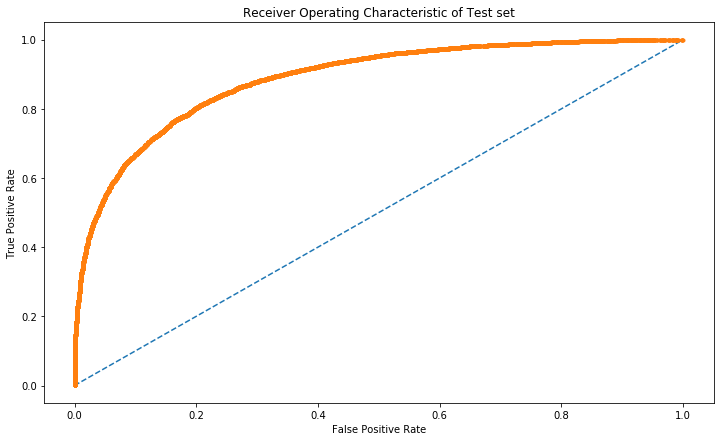

--- 5.627611875534058 seconds ---


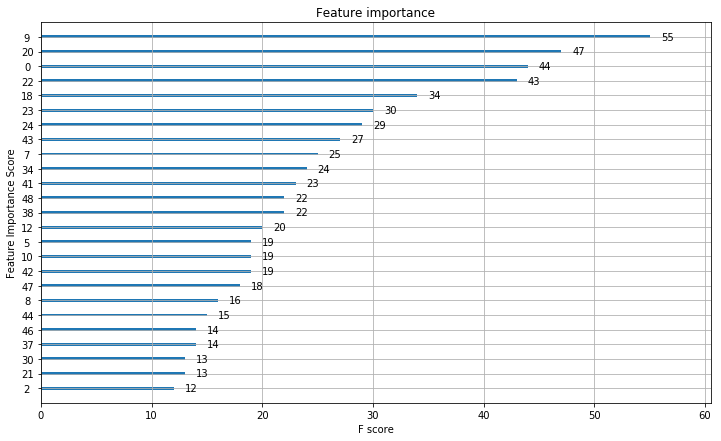

In [31]:
# Trainig the model on default parameters

import time
start_time = time.time()

xgb5= XGBClassifier(objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27,n_jobs =-1)

AVG_pred,AVG_predprob,AVG_accuracy,AVG_Auc_score=modelfit(xgb5,AVG_TR,train_y,AVG_TES,test_y)

print("--- %s seconds ---" % (time.time() - start_time))


f1=0.926 auc=0.971 ap=0.971


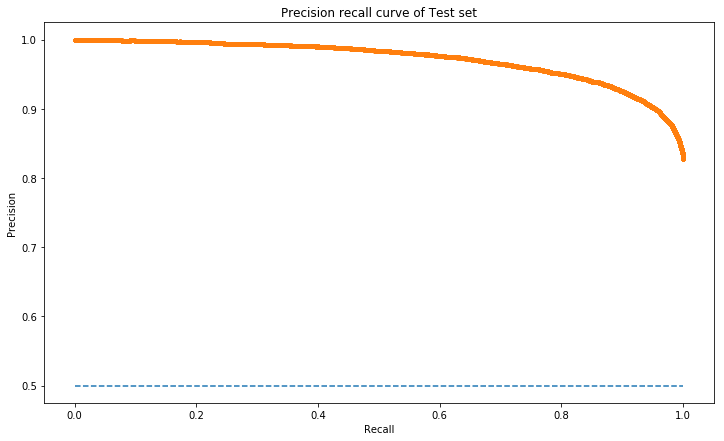

In [32]:
Prec_rec_curve(test_y,AVG_predprob,AVG_pred)

______Confusion Matrix of the model______

[[ 1932  3299]
 [  583 24186]]


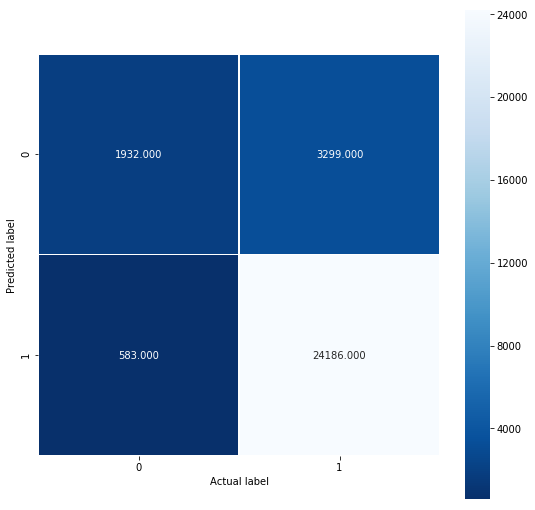


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |           87.06           |
|       Classification_error      |           12.94           |
|          True positive          |           24186           |
|          False positive         |            3299           |
|          True negative          |            1932           |
|          False negative         |            583            |
|        True positive rate       |     97.64625136259033     |
|       False negative rate       |     2.3537486374096654    |
|        True negative rate       |     36.933664691263616    |
|       False positive rate       |     63.06633530873638     |
|         Precision value         |    

In [33]:
Confusion_metric(test_y,AVG_pred)

## Tuning the Hyperparameter with Gridsearch technique

In [52]:
import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,400,500,1000,1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
Max_depth=[1,2,3,4,5]

#Creating dictionary of parameters to be considered
avg_param= dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=Max_depth) 

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(avg_param,AVG_TR,train_y,n_estimators,"n_estimators")


print("--- %s seconds ---" % (time.time() - start_time))


Best: 0.899877 using {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
0.665622 (0.011871) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 100}
0.671159 (0.011266) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 400}
0.671211 (0.011291) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 500}
0.675543 (0.011546) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1000}
0.709778 (0.030664) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1500}
0.732602 (0.006058) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100}
0.739969 (0.005019) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 400}
0.740469 (0.005585) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 500}
0.746107 (0.007079) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 1000}
0.749124 (0.007413) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 1500}
0.770720 (0.006228) with:


Model Report
Accuracy : 0.8843
AUC Score (Train): 0.904509


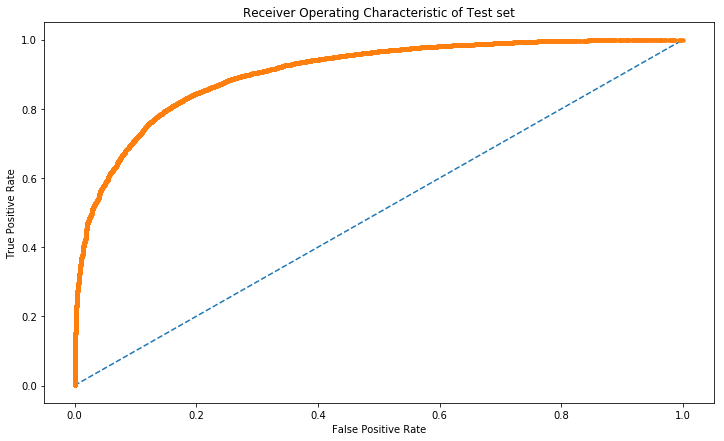

--- 44.35127115249634 seconds ---


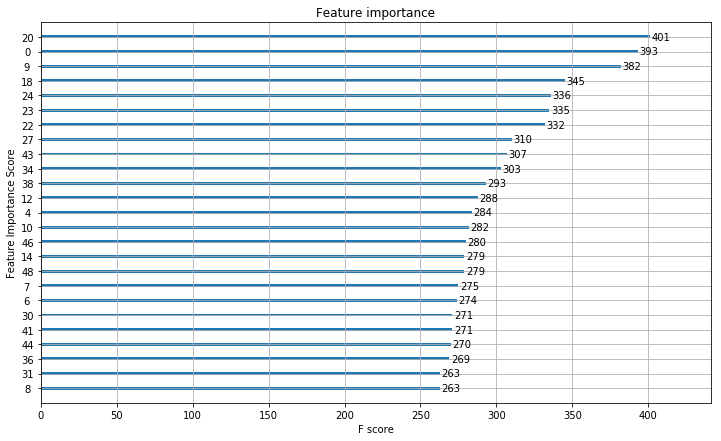

In [34]:
# Trainig the model on default parameters

import time
start_time = time.time()

xgb6= XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 n_jobs =-1)

avg_Pred,avg_Predprob,avg_Acc,avg_Auc_Score=modelfit(xgb6,AVG_TR,train_y,AVG_TES,test_y)

print("--- %s seconds ---" % (time.time() - start_time))
  

f1=0.932 auc=0.976 ap=0.976


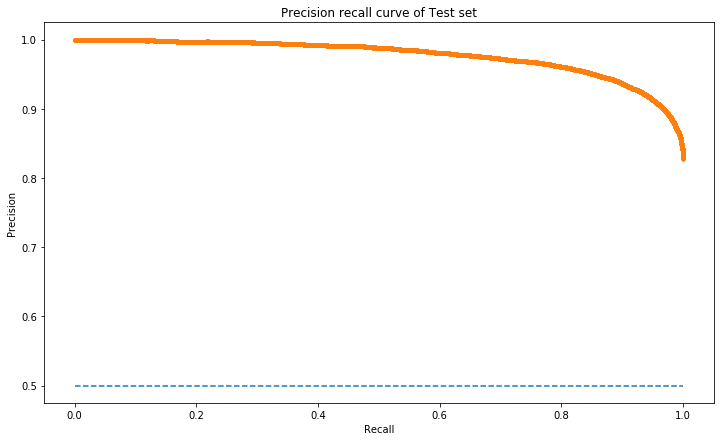

In [35]:
Prec_rec_curve(test_y,avg_Predprob,avg_Pred)

### Confusion matrix of the above model is as follows

[[ 2692  2539]
 [  933 23836]]


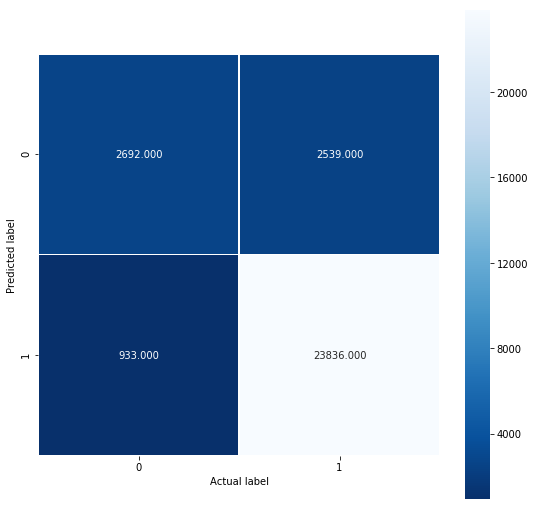


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |     88.42666666666666     |
|       Classification_error      |     11.573333333333332    |
|          True positive          |           23836           |
|          False positive         |            2539           |
|          True negative          |            2692           |
|          False negative         |            933            |
|        True positive rate       |     96.23319471920546     |
|       False negative rate       |     3.766805280794541     |
|        True negative rate       |     51.46243548078762     |
|       False positive rate       |     48.53756451921239     |
|         Precision value         |    

In [36]:
Confusion_metric(test_y,avg_Pred)

### Observations
<ul>
    <li>After tuning the hyperparameters the model's AUC score increased further hence improvement is seen over the Xg-boost model.</li>
    <li>The model is sensible as the Auc score is perfectly 0.974 so the model make sense which can be seen on the ROC curve.</li>
    <li>So the model has successfully classiffied the positive and negative reviews properly of Average Word-to-vec vectorized technique.</li>
    <li>I think only the 3 parameters is not enough and the model can be improved further by feature engineering and by tuning other parameters.</li>
    <li>Let's try other vectorization technique which is TF-IDF Weighted word-to-vectorization technique.</li>
    

## Implementing the TF-IDF Weighted Word-to-vectorization technique

In [37]:
#Function for implementing Average-word-to vectorization technique

def Tf_idf_vector( X_tr,train_list,test_list,model,words):
    
    Tfidf_vector=TfidfVectorizer()
    Tf_train=Tfidf_vector.fit_transform( X_tr)
    dictionary = dict(zip(Tfidf_vector.get_feature_names(), list(Tfidf_vector.idf_)))
   
    Train_sentence_list=train_list
    Test_sentence_list=test_list
    w2v_words=words
    w2v_model= model
    
    train_list_vector=[]
    row=0
    for sentence in  Train_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tfidf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_train[row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec +=(vec *tf_idf)
                weight_tfidf_sum +=tf_idf
        if weight_tfidf_sum !=0:
            word_2_vec /=weight_tfidf_sum
        train_list_vector.append(word_2_vec)
        row +=1
    print(len(train_list_vector))
    print(len(train_list_vector[0]))

    
    TEST_LIST_VECTOR=[]
    Row=0
    for sentence in  Test_sentence_list:
        word_2_vec=np.zeros(50)
        weight_tf_sum=0
        for word in sentence:
            if word in w2v_words:
                vec=w2v_model.wv[word]
            #tfidf_value=Tf_test[Row,Dimension.index(word)]
                tf_idf = dictionary[word]*sentence.count(word)
                word_2_vec += (vec* tf_idf)
                weight_tf_sum += tf_idf
        if weight_tf_sum !=0:
            word_2_vec /=weight_tf_sum
        TEST_LIST_VECTOR.append(word_2_vec)
        row += 1
    print(len(TEST_LIST_VECTOR))
    print(len(TEST_LIST_VECTOR[0]))

    return train_list_vector,TEST_LIST_VECTOR




## Vectorizing the inputs into TF-IDF Weighted words

In [38]:
Xtrain=X_tr["CleanedText"]

tfidf_tr,tfidf_test=Tf_idf_vector(Xtrain,tr_list,tes_list,model,words)

70000
50
30000
50


### Converting the inputs from List to Data-frames 

In [39]:

tfw2v_train=pd.DataFrame(tfidf_tr)
print(tfw2v_train.shape)

tfw2v_test=pd.DataFrame(tfidf_test)

print(tfw2v_test.shape)


(70000, 50)
(30000, 50)


### Training the XG-Boost model on Test Data with default hyperparameters 


Model Report
Accuracy : 0.8571
AUC Score (Train): 0.853616


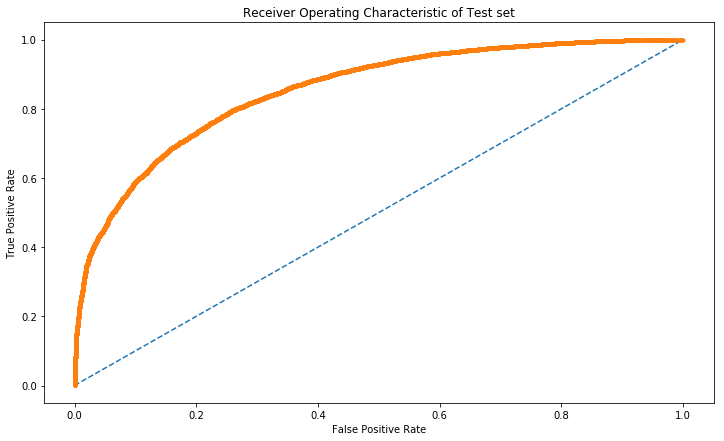

--- 5.638618230819702 seconds ---


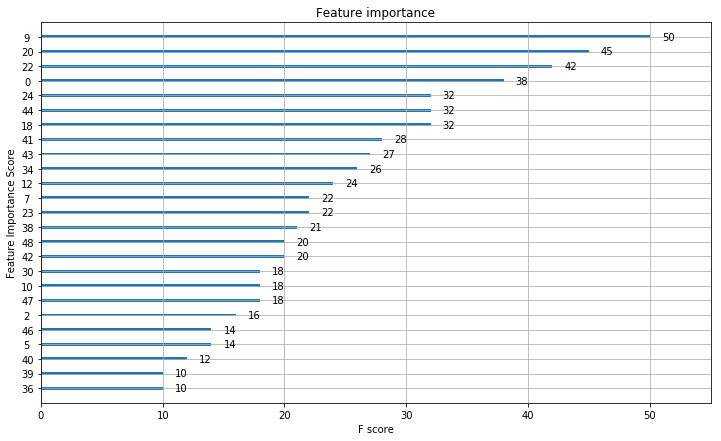

In [40]:
# Trainig the model on default parameters

import time
start_time = time.time()

xgb7= XGBClassifier(objective= 'binary:logistic',nthread=4,n_jobs =-1)

tw2v_pred,tw2v_predprob,tw2v_accuracy,tw2v_Auc_score=modelfit(xgb7,tfw2v_train,train_y,tfw2v_test,test_y)

print("--- %s seconds ---" % (time.time() - start_time))


f1=0.919 auc=0.962 ap=0.962


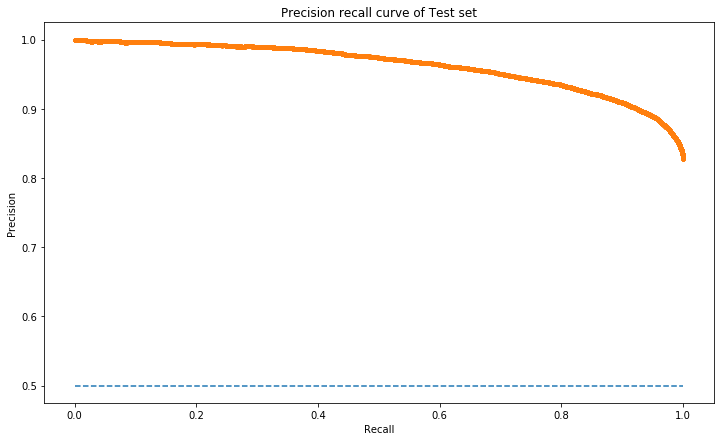

In [41]:
Prec_rec_curve(test_y,tw2v_predprob,tw2v_pred)

[[ 1403  3828]
 [  459 24310]]


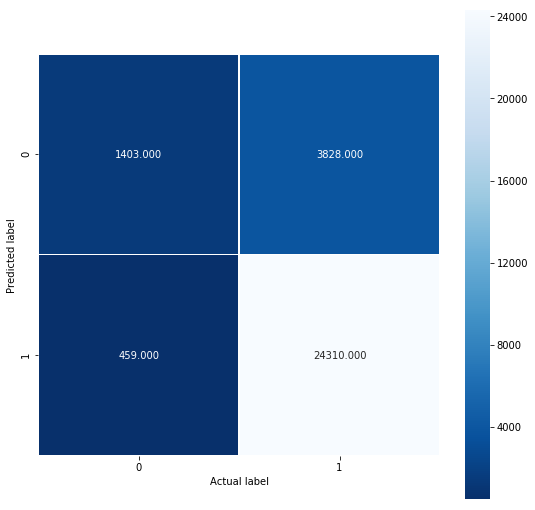


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |           85.71           |
|       Classification_error      |           14.29           |
|          True positive          |           24310           |
|          False positive         |            3828           |
|          True negative          |            1403           |
|          False negative         |            459            |
|        True positive rate       |     98.14687714481812     |
|       False negative rate       |     1.8531228551818806    |
|        True negative rate       |     26.820875549608104    |
|       False positive rate       |      73.1791244503919     |
|         Precision value         |    

In [42]:
Confusion_metric(test_y,tw2v_pred)

## Tuning the Hyperparameter with Gridsearch technique

In [58]:
import time
start_time = time.time()

#Tuning the parameters to be given
n_estimators = [100,400,500,1000,1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
Max_depth=[1,2,3,4,5]

#Creating dictionary of parameters to be considered
tfw2v_param= dict(learning_rate=learning_rate, n_estimators=n_estimators,max_depth=Max_depth) 

#Hyperarameter tuning the parameters using Gridsearch cross_validation technique
Gridsearch_tuning(tfw2v_param,tfw2v_train,train_y,n_estimators,"n_estimators")


print("--- %s seconds ---" % (time.time() - start_time))


Best: 0.872145 using {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1500}
0.652366 (0.032879) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 100}
0.681345 (0.028950) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 400}
0.696702 (0.009711) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 500}
0.704298 (0.008026) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1000}
0.707212 (0.008673) with: {'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 1500}
0.694831 (0.003929) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100}
0.706819 (0.009343) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 400}
0.708422 (0.010106) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 500}
0.714039 (0.010292) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 1000}
0.716976 (0.009587) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 1500}
0.731331 (0.005461) wit

____Testing the above model with optimal hyperparameter values____ 


Model Report
Accuracy : 0.9135
AUC Score (Train): 0.945777


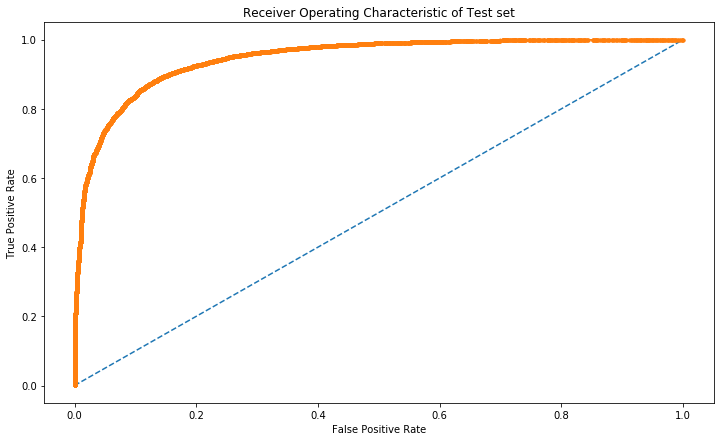

--- 229.15234446525574 seconds ---


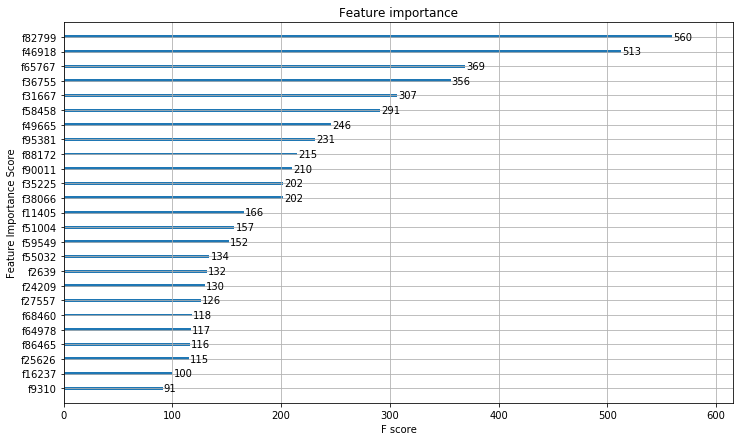

In [43]:

import time
start_time = time.time()

xgb8= XGBClassifier(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=5,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 n_jobs =-1)

Tfy_Predi,Tfy_prob,Tfy_Accurac,Tf_Auc_Scor=modelfit(xgb8,tfx_tr,train_y,tfx_test,test_y)

print("--- %s seconds ---" % (time.time() - start_time))
  

f1=0.949 auc=0.987 ap=0.987


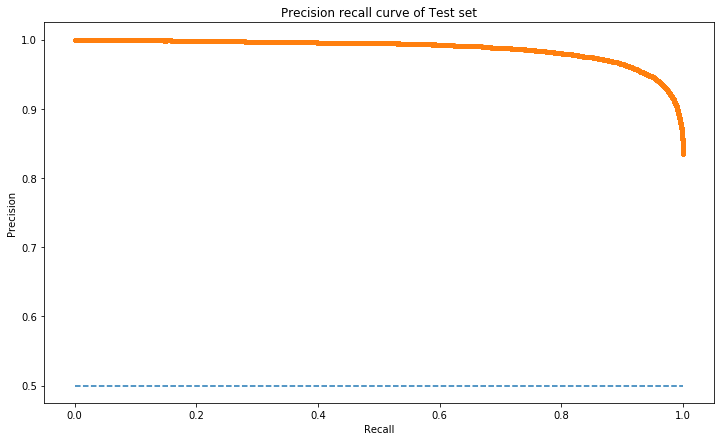

In [44]:
Prec_rec_curve(test_y,Tfy_prob,Tfy_Predi)

[[ 3169  2062]
 [  533 24236]]


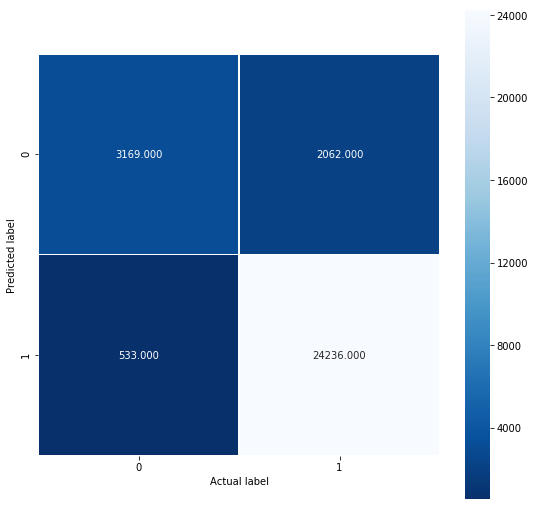


+-------------------------------------------------------------+
| The performance metrics of the above model are as follows:  |
+---------------------------------+---------------------------+
|             Metrics             |           Scores          |
+---------------------------------+---------------------------+
|     Classification accuracy     |           91.35           |
|       Classification_error      |     8.649999999999999     |
|          True positive          |           24236           |
|          False positive         |            2062           |
|          True negative          |            3169           |
|          False negative         |            533            |
|        True positive rate       |      97.8481165973596     |
|       False negative rate       |     2.1518834026403972    |
|        True negative rate       |     60.581150831580956    |
|       False positive rate       |     39.41884916841904     |
|         Precision value         |    

In [45]:
Confusion_metric(test_y,Tfy_Predi)

### Observations
<ul>
    <li>After tuning the hyperparameters the model's AUC score increased further which is seen over the Xg-boost model.</li>
    <li>The model is sensible as the Auc score is  0.945 so the model does not make any sense which can be seen on the ROC curve plot.</li>
    <li>So the model has successfully classifyies the positive and negative reviews properly on Tf-idf weighted word2vec vectorized technique.</li>
    <li>Here the precision-recall curve handles the imbalanced data quite efficiently and give a good AUC score of 0.987 which indicates the model's sensibility.</li>
    <li>I think only the 3 parameters is not enough and the model can be improved further by feature engineering and by tuning other parameters.</li>
    

# <center> Conclusion</center>

In [50]:
conclusion_table()



+------------------------------------------------------------------------------------------+
|           The comparisons of all the vectorizers and scorings are as follows:            |
+--------------------------+-----------+--------------------+------------------------------+
|        Vectorizer        | Algorithm |   ROC_AUC score    | Precision-recall curve score |
+--------------------------+-----------+--------------------+------------------------------+
|       Bag-Of-Words       |  XG-BOOST | 0.890452966060191  |            0.971             |
|          Tf-IDF          |  XG-BOOST | 0.9004960567048436 |            0.974             |
|     Average-word2vec     |  XG-BOOST | 0.9045085517731151 |            0.976             |
| TF-IDF-Weighted-word2vec |  XG-BOOST | 0.9457770259827454 |            0.987             |
+--------------------------+-----------+--------------------+------------------------------+



<ul>
    <li>After implementing the XG-BOOST model over all the vectorizers it is clear that "Accuracy" as a lone metric can't be trusted blindly and there is a need of metrics like ROC-AUC and Prescion-recall to evaluate the model,s performance.</li>
    <li>Generally, the use of ROC curves and precision-recall curves are as follows:</li>
       <ul>
           <li>ROC curves should be used when there are roughly equal numbers of observations for each class.</li>
           <li>Precision-Recall curves should be used when there is a moderate to large class imbalance.</li>
       </ul>
   <li>The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.</li>
    

###  
> <span style="color:black">However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.<span>
    
— The Relationship Between Precision-Recall and ROC Curves, 2006.

###  
> <span style="color:black">[…] the visual interpretability of ROC plots in the context of imbalanced datasets can be deceptive with respect to conclusions about the reliability of classification performance, owing to an intuitive but wrong interpretation of specificity. [Precision-recall curve] plots, on the other hand, can provide the viewer with an accurate prediction of future classification performance due to the fact that they evaluate the fraction of true positives among positive predictions.<span>
    
_The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets, 2015.

    
       
    